# Infer ***lipid body*** - part 9️⃣

--------------
OBJECTIVE: ✅ Infer sub-cellular component ***lipid body***  in order to understand interactome 



Dependencies:
The  ***lipid body***  inference rely on the cytosol mask.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from typing import Optional
import numpy as np
from typing import Optional


from aicssegmentation.core.pre_processing_utils import image_smoothing_gaussian_slice_by_slice
from aicssegmentation.core.utils import hole_filling
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari


### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))
from infer_subc_2d.utils.file_io import (read_czi_image, 
                                                                    list_image_files)
from infer_subc_2d.utils.img import *
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )        

from infer_subc_2d.organelles import fixed_infer_soma, fixed_infer_nuclei, infer_cytosol, find_optimal_Z


%load_ext autoreload
%autoreload 2


test_img_n = TEST_IMG_N


## SETUP

In [2]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [3]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 
img_2D = select_z_from_raw(img_data, optimal_Z)


choosing _optimal_ z-slice::: 8


## GET SOMA MASK

Find the soma in our chozed Z-slice

In [4]:
soma_mask =  fixed_infer_soma(img_2D) 

## INFER NUCLEI OBJECT


In [5]:
nuclei_object =  fixed_infer_nuclei(img_2D, soma_mask) 


## GET CYTOSOL MASK


In [6]:
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


---------------------

## infer ***lipid body*** 

## summary of steps 

INPUT
- ch 7
- cytosol mask


PRE-PROCESSING
- rescale 
-  median, window 2
-  
CORE-PROCESSING
   - "robust background" 2 STD

POST-PROCESSING
  - n/a

OUTPUT
- object ***lipid body***




NOTE:  consider using [Fibrillarin](https://www.allencell.org/cell-observations/category/fibrillarin) (nucleous marker) workflow from AllenCell.  playground_spotty.ipynb  or maybe [centrin](https://www.allencell.org/cell-observations/category/centrin)


Not a good thing to follow from  the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.


## INPUT prototype

In [7]:
###################
# INPUT
###################
# raw_lipid   = img_2D[LIPID_CH].copy()
raw_lipid = select_channel_from_raw(img_2D, LIPID_CH)


## PRE-PROCESSING prototype

In [8]:
###################
# PRE_PROCESSING
###################
struct_img = min_max_intensity_normalization( raw_lipid)

med_filter_size = 2   
struct_img = median_filter_slice_by_slice( 
                                                                struct_img,
                                                                size=med_filter_size  )

gaussian_smoothing_sigma = 1.34
struct_img = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                    sigma=gaussian_smoothing_sigma,
                                                                                                )


## CORE PROCESSING prototype

In [9]:

###################
# CORE_PROCESSING
###################

threshold_factor = 0.99 #from cellProfiler
thresh_min = .5
thresh_max = 1.
otsu_thresholded = apply_threshold(struct_img, method= "otsu", thresh_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)


## POST-PROCESSING prototype

In [10]:

###################
# POST_PROCESSING
###################
# # wrapper to remoce_small_objects
hole_min = 0
hole_max = 2.5
bw = hole_filling(otsu_thresholded, hole_min=hole_min**2, hole_max=hole_max**2, fill_2d=True)

struct_obj = apply_mask(bw, cytosol_mask)

small_object_width = 4

struct_obj = size_filter_linear_size(struct_obj, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width ** 2, 
                                                         connectivity=1)


lipid_object = struct_obj
lipid_labels = label( lipid_object   )


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [11]:

viewer = napari.view_image(
    lipid_object,
    scale=scale
)



In [12]:

viewer.scale_bar.visible = True
viewer.add_image(
    struct_img,
    scale=scale
)

viewer.add_labels(
    lipid_labels,
    scale=scale
)

<Labels layer 'lipid_labels' at 0x180847040>

In [13]:
viewer.add_image(
    lipid_object,
    scale=scale
)



<Image layer 'lipid_object [1]' at 0x180daf280>

## DEFINE `infer_lipid_body` function

Based on the _prototyping_ above define the function to infer the lipid boty.  


In [14]:
##########################
#  infer_endoplasmic_reticulum
##########################
def _infer_lipid_body(
                            in_img: np.ndarray,
                            cytosol_mask: np.ndarray,
                            median_sz: int,
                            gauss_sig: float,
                            method: str,
                            thresh_factor: float,
                            thresh_min: float,
                            thresh_max: float,
                            max_hole_w: int,
                            small_obj_w: int,
                        ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cytosol_mask: 
        mask of cytosol
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    method: 
        method for applying threshold.  "otsu"  or "li", "triangle", "median", "ave", "sauvola","multi_otsu","muiltiotsu"
    thresh_factor:
        scaling value for threshold
    thresh_min:
        absolute minumum for threshold
    thresh_max:
        absolute maximum for threshold
    max_hole_w: 
        hole filling cutoff for lipid post-processing
    small_obj_w: 
        minimu object size cutoff for lipid post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    lipid_ch = LIPID_CH
    ###################
    # EXTRACT
    ###################    
    lipid = select_channel_from_raw(in_img, lipid_ch)
    ###################
    # PRE_PROCESSING
    ###################                         
    lipid = min_max_intensity_normalization(lipid)

    lipid = median_filter_slice_by_slice(lipid, size=median_sz)

    lipid = image_smoothing_gaussian_slice_by_slice(lipid, sigma=gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    bw = apply_threshold(lipid, 
                                            method= method, 
                                            thresh_factor=thresh_factor, 
                                            thresh_min=thresh_min, 
                                            thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    min_hole_w = 0
    struct_obj = hole_filling(bw, hole_min=min_hole_w**2, hole_max=max_hole_w**2, fill_2d=True)

    struct_obj = apply_mask(struct_obj, cytosol_mask)

    struct_obj = size_filter_linear_size(struct_obj, # wrapper to remove_small_objects which can do slice by slice
                                                            min_size= small_obj_w ** 2, 
                                                            connectivity=1)

    return struct_obj



In [15]:


##########################
#  fixed_infer_lipid_body
##########################
def _fixed_infer_lipid_body(in_img: np.ndarray, cytosol_mask: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cytosol_mask: 
        mask - default=None

    Returns
    -------------
    lipid_body_object
        mask defined extent of liipid body

    """

    median_sz = 2   
    gauss_sig = 1.34
    method = "otsu"
    threshold_factor = 0.99 #from cellProfiler
    thresh_min = .5
    thresh_max = 1.
    max_hole_w = 2.5
    small_obj_w = 4

    return _infer_lipid_body(
        in_img, cytosol_mask, median_sz, gauss_sig, method, threshold_factor, thresh_min, thresh_max, max_hole_w, small_obj_w
    )


# TEST  `infer_lipid_body` function

In [16]:

_lipid_obj =  _fixed_infer_lipid_body(img_2D, cytosol_mask) 

In [17]:
from infer_subc_2d.organelles import fixed_infer_lipid_body

lipid_obj =  fixed_infer_lipid_body(img_2D, cytosol_mask) 

ImportError: cannot import name 'fixed_infer_lipid_body' from 'infer_subc_2d.organelles' (/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles/__init__.py)

## Visualize  2


In [ ]:

viewer.add_image(
    _lipid_obj,
    scale=scale
)

viewer.add_image(
    lipid_obj,
    scale=scale
)
viewer.add_labels(
    label(lipid_obj),
    scale=scale
)

<Labels layer 'Labels' at 0x1889d4ee0>

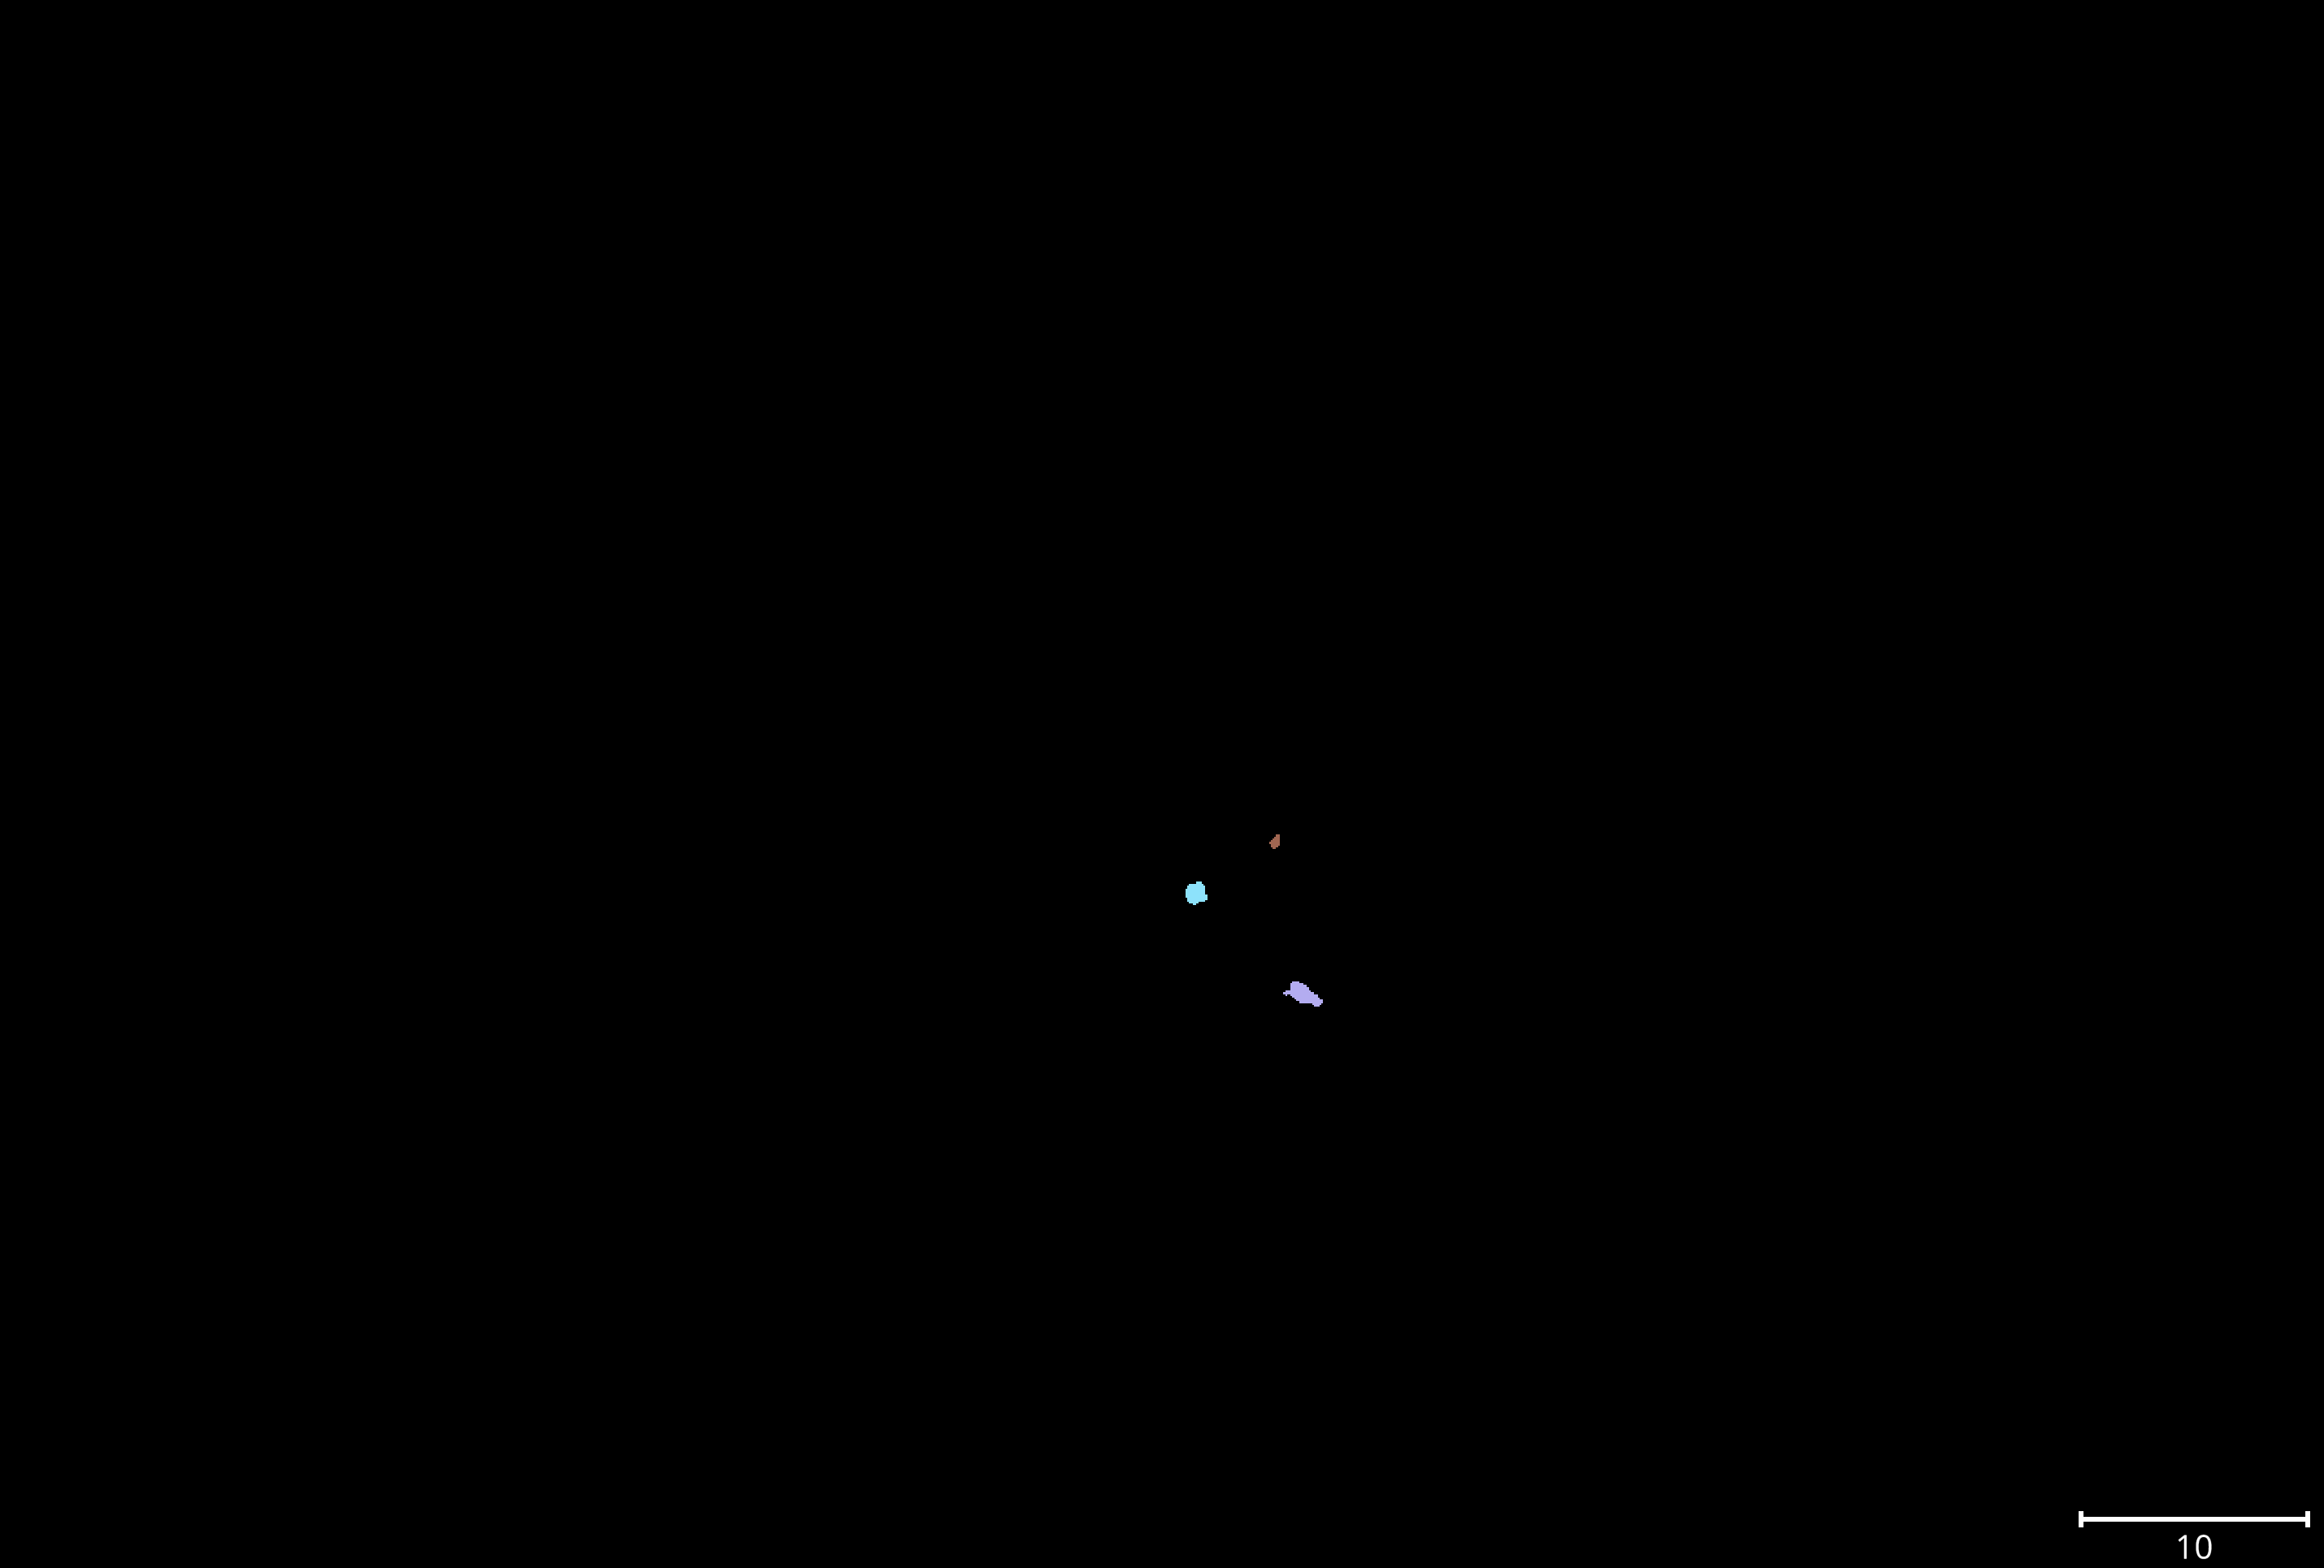

In [ ]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [ ]:
viewer.close()

-----------------
Write the `infer_endoplasmic_reticulum` spec to the widget json 

In [ ]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_lipid=  {
        "name": "infer lipid bodies (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_lipid",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_lipid",_fixed_infer_lipid)

function fixed_infer_lipid is already in all_functions.json


0

In [ ]:

_infer_lipid =  {
        "name": "infer lipid",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_lipid",
        "parameters": {
                "median_sz": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "method": {
                        "data_type": "str",
                        "widget_type": "drop-down",
                        "options": [
                                "otsu",
                                "li",
                                "triangle",
                                "median",
                                "ave_tri_med"
                        ]
                },
                "thresh_factor": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.2,
                        "min": 0.6,
                        "widget_type": "slider"
                },
                "thresh_min": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": .9,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "thresh_max": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.1,
                        "widget_type": "slider"
                },
                "max_hole_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 40,
                        "min": 4,
                        "widget_type": "slider"
                },           
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_lipid", _infer_lipid, overwrite=True )



function infer_lipid is already in all_functions.json
overwriting  infer_lipid


1

##  helper function definitions

Wrappers for vessleness filters

In [ ]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_apply_threshold =  {
        "name": "Apply Threshold",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "apply_threshold",
        "parameters": {
                "method": {
                        "data_type": "str",
                        "widget_type": "drop-down",
                        "options": [
                                "otsu",
                                "li",
                                "triangle",
                                "median",
                                "ave_tri_med"
                        ]
                },
                "thresh_factor": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.2,
                        "min": 0.6,
                        "widget_type": "slider"
                },
                "thresh_min": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": .9,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "thresh_max": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.1,
                        "widget_type": "slider"
                },
        }
}

add_function_spec_to_widget_json("apply_threshold",_apply_threshold,overwrite=True)

function apply_threshold is already in all_functions.json
overwriting  apply_threshold


1

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [ ]:
from infer_subc_2d.constants import LIPID_CH

def make_infer_lipid_step_by_step_from_raw_dict():
    """
    Procedure to infer lipid from linearly unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    soma_mask: np.ndarray
        mask

    Returns
    -------------
    lipid_object
        mask defined extent of NU

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_soma")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytosol")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = LIPID_CH) )
    parent.append(1)
    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(6)

    step_name.append("8")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.34 ))
    parent.append(7)

    step_name.append("9")
    function_name.append("apply_threshold")
    category.append("core")
    parameter_values.append(dict(method = "otsu",
                                                            thresh_factor = 0.99, 
                                                            thresh_min = .5,
                                                            thresh_max = 1.))
    parent.append(8)

    step_name.append("10")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=2.5**2, fill_2d=True))
    parent.append(9)

    step_name.append("11")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([10,4])

    step_name.append("12")
    function_name.append("size_filter_linear_size")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 4**2  ))
    parent.append(6)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [ ]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_lipid_stepbystep_from_raw_dict = make_infer_lipid_step_by_step_from_raw_dict()

write_workflow_json("conf_1.9.lipid_stepbystep_from_raw", infer_lipid_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.9.lipid_stepbystep_from_raw.json')

-------------
## SUMMARY

The above details how the endoplasmic lipid body is inferred.  

###  THATS IT!
